<a href="https://colab.research.google.com/github/emoceanographer/usdanutrients/blob/master/DispersionTesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The goal here is to investigate whether a Gini coefficient or a combination of Gini coefficients and GDP are good predictors for food consumption; we use stunting prevalence as a metric for food consumption outcomes

In [0]:
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile

from scipy import stats
from scipy.optimize import least_squares
import numpy as np
import math
import scipy
import re
import matplotlib.pyplot as plt
import statistics

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path = '/content/drive/My Drive/Colab Notebooks/Nutrition/' + 'gini_explore.xls'

In [0]:
# load the relevant data
gdp_df = pd.read_excel(path, sheet_name='pppGDP', index = 'Country Code')
pop_df = pd.read_excel(path, sheet_name='population', index = 'Country Code')
Gini_df = pd.read_excel(path, sheet_name='GINI', index = 'Country Code')
stunt_df = pd.read_excel(path, sheet_name='stunting', index = 'Country Code')

# Tries looking at food supply vs. stunting

In [0]:
path_fao = '/content/drive/My Drive/Colab Notebooks/Nutrition/' + 'FoodBalanceSheets_E_All_Data.csv'
path_ctry_codes = '/content/drive/My Drive/Colab Notebooks/Nutrition/' + 'fao_ctry_codes.csv'
path_under5 = '/content/drive/My Drive/Colab Notebooks/Nutrition/' + 'percent_under5.csv'
food_df = pd.read_csv(path_fao, encoding='latin')
ctry_codes_df = pd.read_csv(path_ctry_codes)

In [0]:
under5_df = pd.read_csv(path_under5) # Also uses ISO3 country codes
# Want: 'Population ages 00-04, female (% of female population)' 
# and 'Population ages 00-04, male (% of male population)'

In [0]:
supply = food_df[(food_df['Element']=='Food supply (kcal/capita/day)') & (food_df['Item']=='Grand Total')]

In [0]:
protein_supply = food_df[(food_df['Element']=='Protein supply quantity (g/capita/day)') & (food_df['Item']=='Grand Total')]

In [0]:
def logn_fun(params, x, y):
  """ Function 'stunting % = 1/2 + 1/2 erf(ln(x_s - (ln(D) - sigma^2/2))/2)', 
  where D is the average food supply per capita, stunting % is the proportion of 
  the population stunted, x_s is the unknown threshold in food supply space below 
  which stunting occurs, and sigma is the standard deviation for a lognormal 
  distribution """
  # let params[0] be x_s, and params[1] be sigma
  thresh_ln = math.log(params[0])
  food_ln = [(math.log(X) - (params[1]**2)/2) for X in x]
  erf_fun = [scipy.special.erf((thresh_ln - food_ln[i])/(2*params[1])) for i in range(0,(len(y)-1))]
  res_fun = [(0.5 + 0.5*erf_fun[i] - y[i]) for i in range(0,(len(y)-1))]
  return res_fun

In [0]:
def logn_fun_fixed_xs(params, x, y):
  x_s = 30
  thresh_ln = math.log(x_s)
  food_ln = [(math.log(X) - (params[0]**2)/2) for X in x]
  erf_fun = [scipy.special.erf((thresh_ln - food_ln[i])/(2*params[0])) for i in range(0,(len(y)-1))]
  res_fun = [(0.5 + 0.5*erf_fun[i] - y[i]) for i in range(0,(len(y)-1))]
  return res_fun

In [0]:
def ctry_regression(supply,params0,whichfun):
# Supply uses 'FAOSTAT' ('Area Code' in supply dataframe); stunt_df uses 'ISO3' ('Country Code')
  ctry_list = list(stunt_df['Country Code'].unique())
  ctry_data = {}
  for country in ctry_list:
    ctry_in_FAO = sum(ctry_codes_df['ISO3']==country)
    if ctry_in_FAO > 0: # it exists in FAO's list
      idx = ctry_codes_df.index[ctry_codes_df['ISO3']==country].tolist()
      FAO_area = int(ctry_codes_df.iloc[idx]['FAOSTAT']) # gets FAO area code
      if FAO_area in supply['Area Code'].values:
        ctry_name = list(ctry_codes_df.iloc[idx]['Short name'])[0]

        stunt_ctry = stunt_df[stunt_df['Country Code']==country]
        supply_ctry = supply[supply['Area Code']==FAO_area]
        under5_ctry = under5_df[under5_df['Country Code']==country]
        # gets the stunting percentage for years that it exists and the corresponding food amts
        # for those same years
        data = {}
        data['Food'] = {}
        data['Stunting'] = {}
        data['Child_percent'] = {}
        
        for col in stunt_ctry.columns: 
          if re.match(r'^\d{4}$', str(col)): # if it looks like a year
            temp = stunt_ctry[col]
            if not math.isnan(temp):
              data['Stunting'][str(col)] = float(temp)
              if col < 2014: # FAO data only goes to 2013
                supplyID = 'Y'+str(col)

                data['Food'][str(col)] = float(supply_ctry[supplyID])
              # gets percent of population below 5 years
              colID = str(col) + ' [YR' + str(col) + ']' 

              f_vals = (under5_ctry[under5_ctry['Series Name'] == 'Population ages 00-04, female (% of female population)'])
              m_vals = (under5_ctry[under5_ctry['Series Name'] == 'Population ages 00-04, male (% of male population)'])
              if not f_vals[colID].values in ['..']:
                f_percent = float(f_vals[colID])
              else:
                f_percent = np.nan

              if not m_vals[colID].values in ['..']:
                m_percent = float(m_vals[colID])
              else: 
                m_percent = np.nan

              ch_percent = f_percent + m_percent
              data['Child_percent'][str(col)] = ch_percent

        # Non-linear fitting
        years = list(data['Food'].keys())
        stunting = []
        food_avg = []
        for x in years:
          if not math.isnan(data['Food'][x]):
            ch_percent = data['Child_percent'][x]
            food_avg.append(data['Food'][x])
            stunting.append(data['Stunting'][x]/100*ch_percent/100)
        if country == 'YEM':
          print(stunting)
        #print(ctry_name)
        if len(food_avg) > 4:
          if whichfun == 'logn':
            res_lsq = least_squares(logn_fun, params0, args=(food_avg, stunting), bounds = (0,np.inf))
            data['Regression x_s'] = res_lsq.x[0]
            data['Regression sigma'] = res_lsq.x[1]
          if whichfun == 'fixedxs':
            res_lsq = least_squares(logn_fun_fixed_xs, params0[1], args=(food_avg, stunting), bounds = (0,np.inf))
            data['Regression sigma'] = res_lsq.x[0]
          data['Country Name'] = ctry_name
        ctry_data[country] = data
  return ctry_data


In [164]:
ctry_protein_data = ctry_regression(protein_supply,[30,2],'fixedxs')

[0.2261508719016, 0.2022995031624, 0.23190598360499998, 0.19278733953250005, 0.1442756630286, 0.141862447008]


In [0]:
Gini_df = Gini_df.set_index('Country Code')

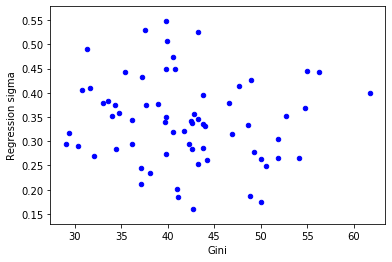

In [165]:
ctry_protein_df = pd.DataFrame.from_dict(ctry_protein_data, orient = 'index')

# Make Gini coefficient average into a dictionary by country code so we can append to our existing df
years = [col for col in Gini_df.columns if re.match(r'^\d{4}$', str(col))]
Gini_df['avg'] = Gini_df[years].mean(axis=1)
ctry_protein_df['Gini'] = Gini_df['avg']

ctry_protein_df.plot(kind='scatter',x='Gini',y='Regression sigma',color='blue')
plt.show()

In [0]:
ctry_protein_df['Regression x_s'].hist(bins=10)

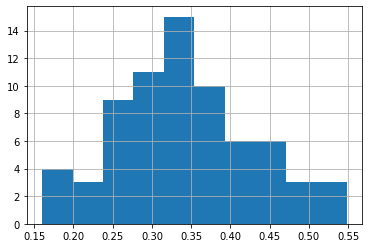

In [166]:
ctry_protein_df['Regression sigma'].hist(bins=10)

In [138]:

ctry_slice

,Food,Stunting,Child_percent,Regression sigma,Country Name,Gini
YEM,"{'1991': 55.15, '1996': 54.63, '1997': 54.75, ...","{'1991': 52.4, '1996': 50.4, '1997': 59.3, '20...","{'1991': 43.15856334, '1996': 40.13879031, '19...",0.44328,Yemen,35.466667


In [0]:
# Makes a plot of a country's distribution
country = 'Zimbabwe'
ctry_slice = ctry_protein_df[ctry_protein_df['Country Name']==country]
x_vals = np.arange(.1,80,1)
sig = float(ctry_slice['Regression sigma'])

mean_food = statistics.mean([ctry_slice['Food'].values[0][x] for x in ctry_slice['Food'].values[0].keys()])
mu = math.log(mean_food) - sig**2/2
#stp = [1/2 + 1/2*scipy.special.erf((math.log(x) - (math.log(mean_food) - sig**2/2))/(2*sig)) for x in x_vals]
#inner_part = [-(math.log(x) - mu)**2/(2*sig**2) for x in x_vals]
stp = [1/(x*sig*(2*3.14)**.5)*math.exp(-(math.log(x) - mu)**2/(2*sig**2)) for x in x_vals]# here pdf

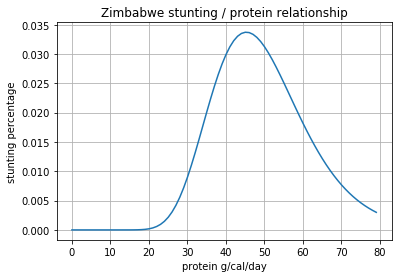

In [168]:
fig, ax = plt.subplots()
ax.plot(x_vals,stp)
ax.set(xlabel = 'protein g/cal/day', ylabel = 'stunting percentage',
       title = country + ' stunting / protein relationship')
ax.grid()

plt.show()

In [149]:
ctry_protein_df

,Food,Stunting,Child_percent,Regression sigma,Country Name,Gini
AFG,"{'1997': 56.82, '2004': 55.24, '2013': 58.25}","{'1997': 53.2, '2004': 59.3, '2013': 40.9}","{'1997': 39.67586244, '2004': 38.7442031399999...",NaN,NaN,NaN
AGO,"{'1996': 37.02, '2007': 47.9}","{'1996': 61.7, '2007': 29.2, '2016': 37.6}","{'1996': 38.18894439, '2007': 38.25162769, '20...",NaN,NaN,47.350000
ALB,"{'1997': 89.03, '2000': 90.39, '2005': 98.24, ...","{'1997': 20.4, '2000': 39.2, '2005': 27.0, '20...","{'1997': 19.959173512, '2000': 17.8783782, '20...",NaN,NaN,29.660000
ARE,{},{},{},NaN,NaN,NaN
ARG,"{'1994': 100.93, '1996': 100.3, '2005': 96.09}","{'1994': 7.1, '1996': 16.9, '2005': 8.2}","{'1994': 20.83628799, '1996': 20.30782842, '20...",NaN,NaN,46.141379
...,...,...,...,...,...,...
WSM,{'1999': 72.21},"{'1999': 6.4, '2014': 4.7}","{'1999': 29.53072819, '2014': 29.705114860000002}",NaN,NaN,40.466667
YEM,"{'1991': 55.15, '1996': 54.63, '1997': 54.75, ...","{'1991': 52.4, '1996': 50.4, '1997': 59.3, '20...","{'1991': 43.15856334, '1996': 40.13879031, '19...",0.443273,Yemen,35.466667
ZAF,"{'1994': 73.69, '1995': 73.33, '1999': 72.92, ...","{'1994': 31.5, '1995': 28.7, '1999': 30.1, '20...","{'1994': 25.610521560000002, '1995': 24.695769...",0.399366,South Africa,61.714286
ZMB,"{'1992': 51.47, '1995': 53.31, '1996': 52.05, ...","{'1992': 46.4, '1995': 58.1, '1996': 48.6, '19...","{'1992': 36.83655805, '1995': 36.43727495, '19...",0.351375,Zambia,52.688889


In [0]:
# Supply uses 'FAOSTAT' ('Area Code' in supply dataframe); stunt_df uses 'ISO3' ('Country Code')
ctry_list = list(stunt_df['Country Code'].unique())
ctry_data = {}
for country in ctry_list:
  ctry_in_FAO = sum(ctry_codes_df['ISO3']==country)
  if ctry_in_FAO > 0: # it exists in FAO's list
    idx = ctry_codes_df.index[ctry_codes_df['ISO3']==country].tolist()
    FAO_area = int(ctry_codes_df.iloc[idx]['FAOSTAT']) # gets FAO area code
    if FAO_area in supply['Area Code'].values:
      ctry_name = list(ctry_codes_df.iloc[idx]['Short name'])[0]

      stunt_ctry = stunt_df[stunt_df['Country Code']==country]
      supply_ctry = supply[supply['Area Code']==FAO_area]

      # gets the stunting percentage for years that it exists and the corresponding food amts
      # for those same years
      data = {}
      data['Food'] = {}
      data['Stunting'] = {}

      for col in stunt_ctry.columns: 
        if re.match(r'^\d{4}$', str(col)): # if it looks like a year
          temp = stunt_ctry[col]
          if not math.isnan(temp):
            data['Stunting'][str(col)] = float(temp)
            if col < 2014: # FAO data only goes to 2013
              supplyID = 'Y'+str(col)
              if country == 'GNQ':
                print(supply_ctry)
              data['Food'][str(col)] = float(supply_ctry[supplyID])
              
      # Non-linear fitting
      years = list(data['Food'].keys())
      stunting = []
      food_avg = []
      for x in years:
        if not math.isnan(data['Food'][x]):
          food_avg.append(data['Food'][x])
          stunting.append(data['Stunting'][x]/100)
        
      print(ctry_name)
      params0 = [1500, 1]
      if len(food_avg) > 0:
        res_lsq = least_squares(logn_fun, params0, args=(food_avg, stunting), loss='soft_l1', bounds = (0,np.inf))
        data['Regression x_s'] = res_lsq.x[0]
        data['Regression sigma'] = res_lsq.x[1]
        data['Country Name'] = ctry_name
      ctry_data[country] = data
      

In [91]:
ctry_df = pd.DataFrame.from_dict(ctry_data, orient = 'index')
ctry_df

,Food,Stunting,Regression x_s,Regression sigma,Country Name
AFG,"{'1997': 1874.0, '2004': 1967.0, '2013': 2090.0}","{'1997': 53.2, '2004': 59.3, '2013': 40.9}",1.285085e-07,7.070699,Afghanistan
AGO,"{'1996': 1731.0, '2007': 2173.0}","{'1996': 61.7, '2007': 29.2, '2016': 37.6}",1.499114e+03,1.102645,Angola
ALB,"{'1997': 2725.0, '2000': 2734.0, '2005': 2874....","{'1997': 20.4, '2000': 39.2, '2005': 27.0, '20...",1.318569e+03,0.664526,Albania
ARE,{},{},NaN,NaN,NaN
ARG,"{'1994': 3155.0, '1996': 3156.0, '2005': 3107.0}","{'1994': 7.1, '1996': 16.9, '2005': 8.2}",1.349569e+02,1.349133,Argentina
...,...,...,...,...,...
WSM,{'1999': 2708.0},"{'1999': 6.4, '2014': 4.7}",1.500000e+03,1.000000,Samoa
YEM,"{'1991': 2029.0, '1996': 2034.0, '1997': 2051....","{'1991': 52.4, '1996': 50.4, '1997': 59.3, '20...",2.047079e+03,0.321752,Yemen
ZAF,"{'1994': 2826.0, '1995': 2810.0, '1999': 2835....","{'1994': 31.5, '1995': 28.7, '1999': 30.1, '20...",2.457303e+02,1.584639,South Africa
ZMB,"{'1992': 1983.0, '1995': 2050.0, '1996': 2034....","{'1992': 46.4, '1995': 58.1, '1996': 48.6, '19...",2.700721e-08,7.124829,Zambia


(1) find all the non-NaN entries in stunting
(2) pick out the food average for that year
(3) run a non-linear regression (see notebook) to get \sigma
(4) try on some other countries
(5) see if those correlate with Gini coefficients

In [0]:
Gini_df = Gini_df.set_index('Country Code')

In [92]:
# Make Gini coefficient average into a dictionary by country code so we can append to our existing df
years = [col for col in Gini_df.columns if re.match(r'^\d{4}$', str(col))]
Gini_df['avg'] = Gini_df[years].mean(axis=1)
ctry_df['Gini'] = Gini_df['avg']
ctry_df.head()

,Food,Stunting,Regression x_s,Regression sigma,Country Name,Gini
AFG,"{'1997': 1874.0, '2004': 1967.0, '2013': 2090.0}","{'1997': 53.2, '2004': 59.3, '2013': 40.9}",1.285085e-07,7.070699,Afghanistan,NaN
AGO,"{'1996': 1731.0, '2007': 2173.0}","{'1996': 61.7, '2007': 29.2, '2016': 37.6}",1.499114e+03,1.102645,Angola,47.350000
ALB,"{'1997': 2725.0, '2000': 2734.0, '2005': 2874....","{'1997': 20.4, '2000': 39.2, '2005': 27.0, '20...",1.318569e+03,0.664526,Albania,29.660000
ARE,{},{},NaN,NaN,NaN,NaN
ARG,"{'1994': 3155.0, '1996': 3156.0, '2005': 3107.0}","{'1994': 7.1, '1996': 16.9, '2005': 8.2}",1.349569e+02,1.349133,Argentina,46.141379


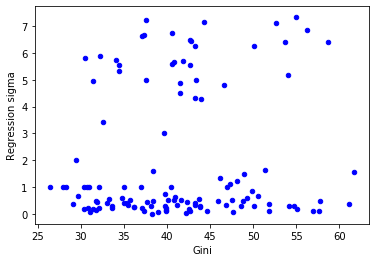

# Gini vs. Stunting

In [0]:
# Gini versus stunting
Gini_df.set_index("Country Code", inplace=True)
stunt_df.set_index("Country Code", inplace=True)


In [0]:

# cycle through each year, country pair for both sets
for i in range(0,len(Gini_df)): # cycles through number of countries
  for j in range(1960,2018): # cycles through years

264

In [0]:
gdp_df.loc['ABW']

Country Name                                         Aruba
Indicator Name    GDP, PPP (constant 2011 international $)
Indicator Code                           NY.GDP.MKTP.PP.KD
1960                                                   NaN
1961                                                   NaN
1962                                                   NaN
1963                                                   NaN
1964                                                   NaN
1965                                                   NaN
1966                                                   NaN
1967                                                   NaN
1968                                                   NaN
1969                                                   NaN
1970                                                   NaN
1971                                                   NaN
1972                                                   NaN
1973                                                   N